# Présentation du travail pour le datachallenge
Víctor Camps, Aldric Bahna

## Exploration des données

Import des bibliothèques utiles

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import warnings

Chemin vers les données

In [54]:
data_dir = Path('data')
x_train_dir = data_dir / 'x_train_images'
x_test_dir = data_dir / 'x_test_images'
y_train_file = data_dir / 'y_train_labels' / 'Y_train_T9NrBYo.csv'

In [55]:
# Load training labels from CSV
print("Loading training labels...")
y_train = pd.read_csv(y_train_file, index_col=0)
print(f"Loaded {len(y_train)} training patches")
print(f"\nDataset shape: {y_train.shape}")
print(f"Sample patch names: {list(y_train.index[:5])}")
print(f"\nFirst few values of first patch:")
print(y_train.iloc[0, :20])

Loading training labels...
Loaded 4410 training patches

Dataset shape: (4410, 43520)
Sample patch names: ['well_2_section_22_patch_1', 'well_6_section_10_patch_3', 'well_1_section_10_patch_6', 'well_6_section_10_patch_15', 'well_1_section_14_patch_6']

First few values of first patch:
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    2
19    2
Name: well_2_section_22_patch_1, dtype: int64


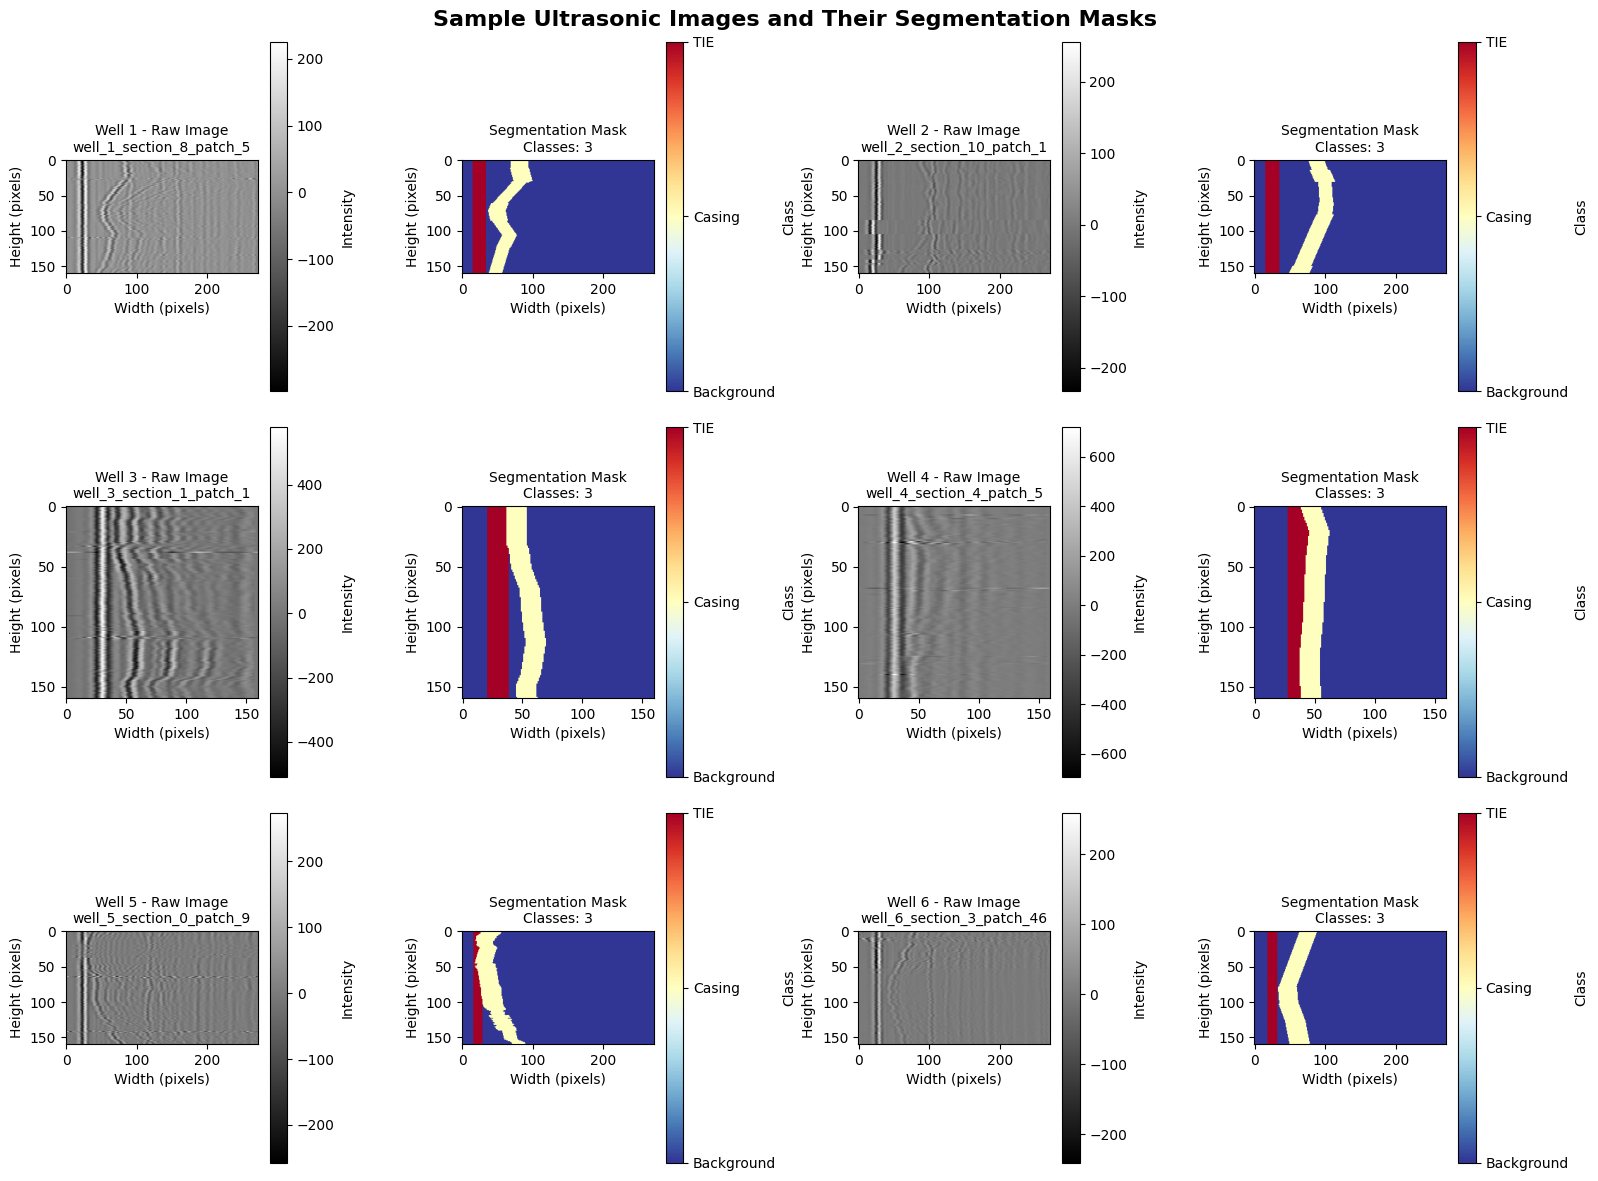

In [56]:
# Visualize samples from different wells
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Sample Ultrasonic Images and Their Segmentation Masks', fontsize=16, fontweight='bold')

well_samples = ['1', '2', '3', '4', '5', '6']
sample_count = 0

for well in well_samples:
    # Get patches from this well
    well_patches = [p for p in y_train.index if f'well_{well}_' in p]
    
    if well_patches and sample_count < 6:
        # Sample middle patch from well
        sample_idx = len(well_patches) // 2
        patch_name = well_patches[sample_idx]
        
        # Load image
        image_path = x_train_dir / f"{patch_name}.npy"
        image = np.load(image_path)
        
        # Load label
        label_values = np.array([v for v in y_train.loc[patch_name] if v != -1])
        label = label_values.reshape(160, -1)
        
        # Plot image
        row = sample_count // 2
        col = (sample_count % 2) * 2
        
        if row < 3:
            # Raw image
            ax1 = axes[row, col]
            im1 = ax1.imshow(image, cmap='gray')
            ax1.set_title(f'Well {well} - Raw Image\n{patch_name}', fontsize=10)
            ax1.set_xlabel('Width (pixels)')
            ax1.set_ylabel('Height (pixels)')
            plt.colorbar(im1, ax=ax1, label='Intensity')
            
            # Segmentation mask
            ax2 = axes[row, col+1]
            im2 = ax2.imshow(label, cmap='RdYlBu_r', vmin=0, vmax=2)
            ax2.set_title(f'Segmentation Mask\nClasses: {len(np.unique(label))}', fontsize=10)
            ax2.set_xlabel('Width (pixels)')
            ax2.set_ylabel('Height (pixels)')
            cbar = plt.colorbar(im2, ax=ax2, label='Class')
            cbar.set_ticks([0, 1, 2])
            cbar.set_ticklabels(['Background', 'Casing', 'TIE'])
            
            sample_count += 1

plt.tight_layout()
plt.show()

## Structure des données et dimensions

In [63]:
# Extract well and section information from patch names
wells_info = {}

for patch_name in y_train.index:
    parts = patch_name.split('_')
    well_num = parts[1]  # Extract well number from "well_X"
    section_num = parts[3]  # Extract section number from "section_Y"
    
    if well_num not in wells_info:
        wells_info[well_num] = {'sections': set(), 'patches': []}
    
    wells_info[well_num]['sections'].add(int(section_num))
    wells_info[well_num]['patches'].append(patch_name)

# Display summary
print("=" * 70)
print("Résumé des données d'entraînement")
print("=" * 70)

summary_data = []
for well in sorted(wells_info.keys(), key=lambda x: int(x)):
    info = wells_info[well]
    num_patches = len(info['patches'])
    num_sections = len(info['sections'])
    summary_data.append({
        'Well': well,
        'Sections': num_sections,
        'Patches': num_patches,
        'Approx. Size': f"~{num_patches//num_sections}x{num_sections if num_sections == 18 else 36}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print(f"\nNombre de patchs d'entraînement: {len(y_train)}")
print(f"Nombre de puits d'entraînement: {len(wells_info)}")

Résumé des données d'entraînement
Well  Sections  Patches Approx. Size
   1        18      666       ~37x18
   2        36     1152       ~32x36
   3        18      486       ~27x18
   4        18      198       ~11x18
   5        18      288       ~16x18
   6        18     1620       ~90x18

Nombre de patchs d'entraînement: 4410
Nombre de puits d'entraînement: 6


On remarque que l'on a beaucoup plus de patchs venant des puits 2 et 6 par rapport aux puits 4 et 5. On a un déséquilibre important dans la quantité de données, ce qui peut biaiser l'entraînement avec les caractéristiques des puits les plus présents. Ce problème devra donc être traîté en data engineering

In [58]:
# TODO: weight sampling or data augmentation to improve the data
# balance between each well

In [59]:
# Check patch dimensions by sampling patches
patch_dimensions = defaultdict(int)

for i, patch_name in enumerate(y_train.index[:100]):  # Sample first 100 patches
    label_values = np.array([v for v in y_train.loc[patch_name] if v != -1])
    num_pixels = len(label_values)
    
    if num_pixels == 160 * 160:
        patch_dimensions['160x160'] += 1
    elif num_pixels == 160 * 272:
        patch_dimensions['160x272'] += 1
    else:
        patch_dimensions[f'Other ({num_pixels})'] += 1

print("\nDistribution de la taille des patchs:")
for dim, count in sorted(patch_dimensions.items()):
    print(f"  {dim}: {count} patchs")


Distribution de la taille des patchs:
  160x160: 17 patchs
  160x272: 83 patchs


On remarque également que les tailles de puits ne sont pas pareilles (largeur d'image de 160 ou 270 pixels), on peut donc penser qu'il y aura des étapes de preprocessing différentes pour chaque puit 

## Analyse de la distribution des classes

In [60]:
# Analyze class distribution across all training patches
class_names = {
    0: 'Arrière-plan',
    1: 'Casing',
    2: 'TIE'
}
class_counts = {0: 0, 1: 0, 2: 0}  # Background, Casing, TIE
patch_class_presence = {0: 0, 1: 0, 2: 0}  # Count of patches containing each class

for i, patch_name in enumerate(y_train.index):
    if (i + 1) % 500 == 0:
        print(f"  Processed {i+1}/{len(y_train)} patches...", end='\r')
    
    label_values = np.array([v for v in y_train.loc[patch_name] if v != -1])
    
    for class_id in [0, 1, 2]:
        count = np.sum(label_values == class_id)
        class_counts[class_id] += count
        if count > 0:
            patch_class_presence[class_id] += 1

print(f"  Processed {len(y_train)}/{len(y_train)} patches... Done!     \n")

# Calculate statistics
total_pixels = sum(class_counts.values())
total_patches = len(y_train)

print("\n" + "=" * 70)
print("DISTRIBUTION DES TROIS CLASSES")
print("=" * 70)

for class_id in [0, 1, 2]:
    pixel_pct = (class_counts[class_id] / total_pixels) * 100
    patch_pct = (patch_class_presence[class_id] / total_patches) * 100
    
    print(f"\nClasse {class_id} ({class_names[class_id]}):")
    print(f"  Nombre de pixels: {class_counts[class_id]:,} ({pixel_pct:.2f}%)")
    print(f"  Patchs contenant: {patch_class_presence[class_id]:,} ({patch_pct:.2f}%)")
    
print(f"\nNombre de pixels analysés: {total_pixels:,}")
print(f"Nombre de patchs: {total_patches:,}")

  Processed 4410/4410 patches... Done!     


DISTRIBUTION DES TROIS CLASSES

Classe 0 (Arrière-plan):
  Nombre de pixels: 153,256,840 (85.30%)
  Patchs contenant: 4,410 (100.00%)

Classe 1 (Casing):
  Nombre de pixels: 15,970,360 (8.89%)
  Patchs contenant: 4,362 (98.91%)

Classe 2 (TIE):
  Nombre de pixels: 10,438,720 (5.81%)
  Patchs contenant: 4,410 (100.00%)

Nombre de pixels analysés: 179,665,920
Nombre de patchs: 4,410


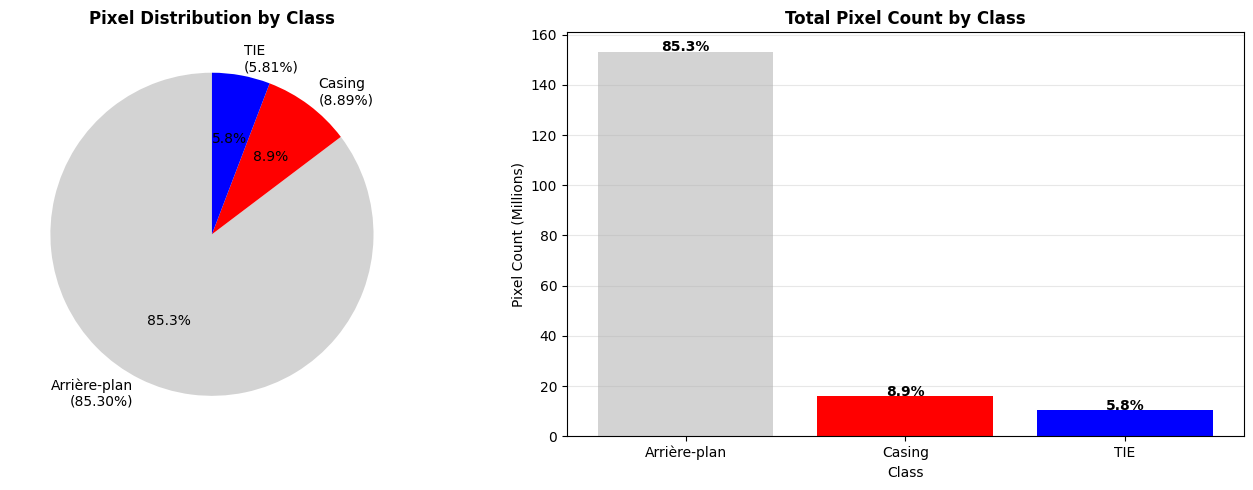

In [61]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Pixel distribution
pixel_percentages = [(class_counts[i] / total_pixels) * 100 for i in [0, 1, 2]]
colors_plot = ['lightgray', 'red', 'blue']
labels_plot = [f'{class_names[i]}\n({pixel_percentages[i]:.2f}%)' for i in range(3)]

axes[0].pie(pixel_percentages, labels=labels_plot, colors=colors_plot, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Pixel Distribution by Class', fontsize=12, fontweight='bold')

# Plot 2: Patch presence distribution
patch_percentages = [(patch_class_presence[i] / total_patches) * 100 for i in [0, 1, 2]]
axes[1].bar(range(3), [class_counts[i] / 1e6 for i in range(3)], color=colors_plot)
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Pixel Count (Millions)')
axes[1].set_title('Total Pixel Count by Class', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(3))
axes[1].set_xticklabels([class_names[i] for i in range(3)])
axes[1].grid(axis='y', alpha=0.3)

for i, (count, pct) in enumerate(zip([class_counts[j] / 1e6 for j in range(3)], pixel_percentages)):
    axes[1].text(i, count + 0.1, f'{pct:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

On remarque que l'on a 85% d'arrière plan, 9% de casing, et 6% de TIE, les classes sont très peu balancées, ce qui peut poser un problème durant l'entraînement, surtout que ce sont les classes d'intérêt qui sont minoritaires.
Les solutions à ça sont déjà d'utiliser une métrique adapter (comme l'IOU proposée dans l'explication du datachallenge) et une pondération des classes.

Regardons maintenant plus en détail par puit

In [62]:
# Detailed statistics per well

well_statistics = []

for well in sorted(wells_info.keys(), key=lambda x: int(x)):
    well_patches = wells_info[well]['patches']
    
    # Count pixels per class in this well
    well_class_counts = {0: 0, 1: 0, 2: 0}
    well_patch_class_presence = {0: 0, 1: 0, 2: 0}
    patch_dims = defaultdict(int)
    
    for patch_name in well_patches:
        label_values = np.array([v for v in y_train.loc[patch_name] if v != -1])
        num_pixels = len(label_values)
        
        # Count dimension types
        if num_pixels == 160 * 160:
            patch_dims['160x160'] += 1
        elif num_pixels == 160 * 272:
            patch_dims['160x272'] += 1
        
        for class_id in [0, 1, 2]:
            count = np.sum(label_values == class_id)
            well_class_counts[class_id] += count
            if count > 0:
                well_patch_class_presence[class_id] += 1
    
    # Calculate percentages
    total_well_pixels = sum(well_class_counts.values())
    
    well_stat = {
        'Well': well,
        'Patches': len(well_patches),
        'Sections': len(wells_info[well]['sections']),
        'Casing %': (well_class_counts[1] / total_well_pixels * 100) if total_well_pixels > 0 else 0,
        'TIE %': (well_class_counts[2] / total_well_pixels * 100) if total_well_pixels > 0 else 0,
        'Dominant Size': max(patch_dims.items(), key=lambda x: x[1])[0] if patch_dims else 'N/A'
    }
    
    well_statistics.append(well_stat)

# Create DataFrame
well_stats_df = pd.DataFrame(well_statistics)
print("=" * 80)
print("DISTRIBUTION POUR CHAQUE PUITS")
print("=" * 80)
print(well_stats_df.to_string(index=False))

print("\n\nObservations clés:")
print(f"  • Puits avec le plus de patchs: Puit {well_stats_df.loc[well_stats_df['Patches'].idxmax(), 'Well']} ({well_stats_df['Patches'].max()} patches)")
print(f"  • Puits avec le moins de patchs: Puit {well_stats_df.loc[well_stats_df['Patches'].idxmin(), 'Well']} ({well_stats_df['Patches'].min()} patches)")
print(f"  • Moyenne de pixels de casing par puit: {well_stats_df['Casing %'].mean():.2f}%")
print(f"  • Moyenne de pixels de TIE par puit: {well_stats_df['TIE %'].mean():.2f}%")

DISTRIBUTION POUR CHAQUE PUITS
Well  Patches  Sections  Casing %     TIE % Dominant Size
   1      666        18  8.708443  5.943534       160x272
   2     1152        36  8.660689  5.181983       160x272
   3      486        18 10.422928 10.596627       160x160
   4      198        18  9.921382  9.052004       160x160
   5      288        18  8.072087  4.386098       160x272
   6     1620        18  8.925692  5.377231       160x272


Observations clés:
  • Puits avec le plus de patchs: Puit 6 (1620 patches)
  • Puits avec le moins de patchs: Puit 4 (198 patches)
  • Moyenne de pixels de casing par puit: 9.12%
  • Moyenne de pixels de TIE par puit: 6.76%


On remarque que la quantité de TIE par puits est assez hétérogène, le puits 3 a plus de deux fois plus de pixels de TIE que le puits 5. On en conclut que probablement les coefficients de pondération des classes seront différents par puits peut-être